# 数据输入

## CSV读取

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpt
from scipy.fftpack import fft,ifft
import seaborn
import csv

## 直接读取

In [2]:
force_01 = pd.read_csv(r'D:\data\20190513\Force\20190513_01_new.csv')
#force_02 = pd.read_csv(r'D:\data\20190513\Force\20190513_02_new.csv')
#force_03 = pd.read_csv(r'D:\data\20190513\Force\20190513_03_new.csv')
#force_04 = pd.read_csv(r'D:\data\20190513\Force\20190513_04_new.csv')

## 预去0处理（可忽略）

force_11 = force_01.query('Fx12!=0 and Fx34!=0 and Fy14!=0')
#force_12 = force_02.query('Fx12!=0 and Fx34!=0 and Fy14!=0')
#force_13 = force_03.query('Fx12!=0 and Fx34!=0 and Fy14!=0')
#force_14 = force_04.query('Fx12!=0 and Fx34!=0 and Fy14!=0')

## 拼接数据

In [3]:
force_all = force_01
#force_all_0 = pd.concat([force_01, force_02, force_03, force_04],ignore_index = True)
#force_all = pd.concat([force_11, force_12, force_13, force_14],ignore_index = True)
print(force_all.shape)

(1000001, 10)


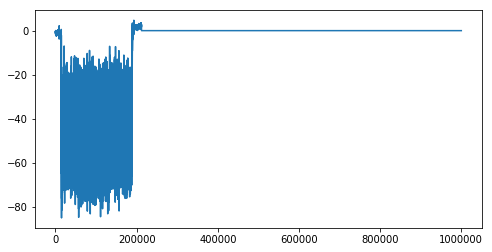

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(force_all.Fx)

# 数据预处理

## 去除末端0数据

(211530,)


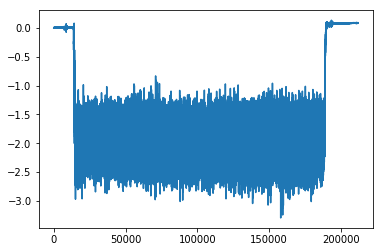

In [5]:
force_all_0 = force_all.query('Fx12!=0 and Fx34!=0 and Fy14!=0')
print(force_all_0.My.shape)
#plt.figure(figsize=(16, 8))
plt.plot(force_all_0.My)

## 去掉停机值

(174820,)


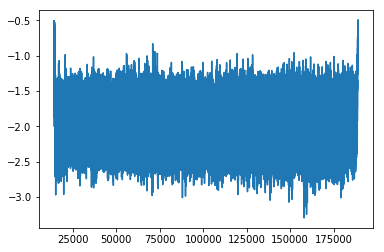

In [6]:
force_all_1 = force_all_0.query('My<-0.5 and My>-4.25')
print(force_all_1.Fx12.shape)
plt.plot(force_all_1.My)

## 选择部分数据处理

(300,)


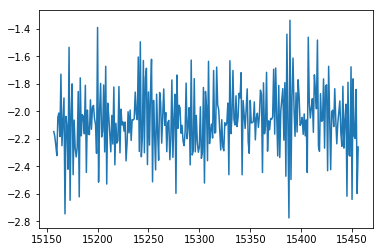

In [7]:
y_front = force_all_1.My[1000:1300]
print(y_front.shape)
plt.plot(y_front)

(1000,)


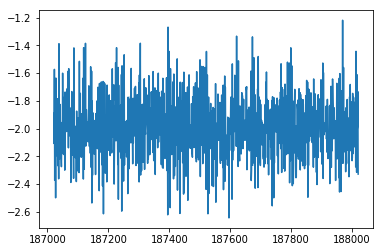

In [8]:
y_back = force_all_1.My[-2000:-1000]
print(y_back.shape)
plt.plot(y_back)

# 深度学习

## 加载模块包，设置参数

In [145]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

learning_rate = 0.05
num_epochs = 2
batch_size = 100
num_classes = 10
num_layers =2
hidden_size = 128
input_size = 28
sequence_length = 28

## 加载数据

In [146]:
data_csv = force_all_1.My
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [147]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

## 定义循环神经网络

In [148]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

In [149]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [150]:
# 划分训练集和测试集，70% 作为训练集
#train_size = int(len(data_X) * 0.7)
#test_size = len(data_X) - train_size
train_X = data_X[3000:3500]
train_Y = data_Y[3000:3500]
test_X = data_X[3500:3800]
test_Y = data_Y[3500:3800]

In [151]:
type(data_X)

numpy.ndarray

In [152]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_Y)

train_x.is_cuda
print(type(train_x))

<class 'torch.Tensor'>


## 改cuda()

train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()
test_y = test_y.cuda()

In [153]:
from torch import nn
from torch.autograd import Variable

In [154]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        #self.reg = self.reg.cuda()
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [155]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [156]:
import time
start = time.time()
# 开始训练
for e in range(500):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.00663
Epoch: 200, Loss: 0.00659
Epoch: 300, Loss: 0.00653
Epoch: 400, Loss: 0.00648
Epoch: 500, Loss: 0.00642
257.4465706348419


In [28]:
import time
start = time.time()
# 开始训练
for e in range(5000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.00349
Epoch: 200, Loss: 0.00332
Epoch: 300, Loss: 0.00341
Epoch: 400, Loss: 0.00335
Epoch: 500, Loss: 0.00416
Epoch: 600, Loss: 0.00349
Epoch: 700, Loss: 0.00330
Epoch: 800, Loss: 0.00418
Epoch: 900, Loss: 0.00376
Epoch: 1000, Loss: 0.00346
Epoch: 1100, Loss: 0.00334
Epoch: 1200, Loss: 0.00319
Epoch: 1300, Loss: 0.00360
Epoch: 1400, Loss: 0.00333
Epoch: 1500, Loss: 0.00317
Epoch: 1600, Loss: 0.00427
Epoch: 1700, Loss: 0.00396
Epoch: 1800, Loss: 0.00381
Epoch: 1900, Loss: 0.00373
Epoch: 2000, Loss: 0.00358
Epoch: 2100, Loss: 0.00348
Epoch: 2200, Loss: 0.00341
Epoch: 2300, Loss: 0.00460
Epoch: 2400, Loss: 0.00350
Epoch: 2500, Loss: 0.00339
Epoch: 2600, Loss: 0.00329
Epoch: 2700, Loss: 0.00350
Epoch: 2800, Loss: 0.00337
Epoch: 2900, Loss: 0.00325
Epoch: 3000, Loss: 0.00351
Epoch: 3100, Loss: 0.00336
Epoch: 3200, Loss: 0.00322
Epoch: 3300, Loss: 0.00336
Epoch: 3400, Loss: 0.00320
Epoch: 3500, Loss: 0.00360
Epoch: 3600, Loss: 0.00336
Epoch: 3700, Loss: 0.00320
Epoch: 380

In [61]:
import time
start = time.time()
# 开始训练
for e in range(500):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.01201
Epoch: 200, Loss: 0.01137
Epoch: 300, Loss: 0.01085
Epoch: 400, Loss: 0.01045
Epoch: 500, Loss: 0.01014
42.21253299713135


In [63]:
import time
start = time.time()
# 开始训练
for e in range(5000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.00860
Epoch: 200, Loss: 0.00836
Epoch: 300, Loss: 0.00824
Epoch: 400, Loss: 0.00820
Epoch: 500, Loss: 0.00818
Epoch: 600, Loss: 0.00815
Epoch: 700, Loss: 0.00809
Epoch: 800, Loss: 0.00777
Epoch: 900, Loss: 0.00687
Epoch: 1000, Loss: 0.00579
Epoch: 1100, Loss: 0.00496
Epoch: 1200, Loss: 0.00464
Epoch: 1300, Loss: 0.00454
Epoch: 1400, Loss: 0.00446
Epoch: 1500, Loss: 0.00442
Epoch: 1600, Loss: 0.00440
Epoch: 1700, Loss: 0.00440
Epoch: 1800, Loss: 0.00439
Epoch: 1900, Loss: 0.00438
Epoch: 2000, Loss: 0.00437
Epoch: 2100, Loss: 0.00436
Epoch: 2200, Loss: 0.00435
Epoch: 2300, Loss: 0.00434
Epoch: 2400, Loss: 0.00433
Epoch: 2500, Loss: 0.00432
Epoch: 2600, Loss: 0.00431
Epoch: 2700, Loss: 0.00430
Epoch: 2800, Loss: 0.00428
Epoch: 2900, Loss: 0.00427
Epoch: 3000, Loss: 0.00425
Epoch: 3100, Loss: 0.00424
Epoch: 3200, Loss: 0.00422
Epoch: 3300, Loss: 0.00420
Epoch: 3400, Loss: 0.00419
Epoch: 3500, Loss: 0.00417
Epoch: 3600, Loss: 0.00416
Epoch: 3700, Loss: 0.00414
Epoch: 380

In [64]:
import time
start = time.time()
# 开始训练
for e in range(5000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.00359
Epoch: 200, Loss: 0.00351
Epoch: 300, Loss: 0.00342
Epoch: 400, Loss: 0.00336
Epoch: 500, Loss: 0.00330
Epoch: 600, Loss: 0.00354
Epoch: 700, Loss: 0.00320
Epoch: 800, Loss: 0.00315
Epoch: 900, Loss: 0.00308
Epoch: 1000, Loss: 0.00301
Epoch: 1100, Loss: 0.00295
Epoch: 1200, Loss: 0.00291
Epoch: 1300, Loss: 0.00288
Epoch: 1400, Loss: 0.00285
Epoch: 1500, Loss: 0.00282
Epoch: 1600, Loss: 0.00280
Epoch: 1700, Loss: 0.00292
Epoch: 1800, Loss: 0.00276
Epoch: 1900, Loss: 0.00274
Epoch: 2000, Loss: 0.00275
Epoch: 2100, Loss: 0.00271
Epoch: 2200, Loss: 0.00269
Epoch: 2300, Loss: 0.00287
Epoch: 2400, Loss: 0.00269
Epoch: 2500, Loss: 0.00265
Epoch: 2600, Loss: 0.00263
Epoch: 2700, Loss: 0.00261
Epoch: 2800, Loss: 0.00265
Epoch: 2900, Loss: 0.00259
Epoch: 3000, Loss: 0.00258
Epoch: 3100, Loss: 0.00265
Epoch: 3200, Loss: 0.00254
Epoch: 3300, Loss: 0.00259
Epoch: 3400, Loss: 0.00251
Epoch: 3500, Loss: 0.00249
Epoch: 3600, Loss: 0.00246
Epoch: 3700, Loss: 0.00244
Epoch: 380

In [65]:
import time
start = time.time()
# 开始训练
for e in range(5000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
end = time.time() - start
print(end)

Epoch: 100, Loss: 0.00220
Epoch: 200, Loss: 0.00219
Epoch: 300, Loss: 0.00217
Epoch: 400, Loss: 0.00219
Epoch: 500, Loss: 0.00217
Epoch: 600, Loss: 0.00212
Epoch: 700, Loss: 0.00207
Epoch: 800, Loss: 0.00221
Epoch: 900, Loss: 0.00212
Epoch: 1000, Loss: 0.00204
Epoch: 1100, Loss: 0.00210
Epoch: 1200, Loss: 0.00205
Epoch: 1300, Loss: 0.00201
Epoch: 1400, Loss: 0.00200
Epoch: 1500, Loss: 0.00189
Epoch: 1600, Loss: 0.00189
Epoch: 1700, Loss: 0.00188
Epoch: 1800, Loss: 0.00188
Epoch: 1900, Loss: 0.00186
Epoch: 2000, Loss: 0.00188
Epoch: 2100, Loss: 0.00186
Epoch: 2200, Loss: 0.00186
Epoch: 2300, Loss: 0.00182
Epoch: 2400, Loss: 0.00184
Epoch: 2500, Loss: 0.00181
Epoch: 2600, Loss: 0.00182
Epoch: 2700, Loss: 0.00179
Epoch: 2800, Loss: 0.00178
Epoch: 2900, Loss: 0.00178
Epoch: 3000, Loss: 0.00177
Epoch: 3100, Loss: 0.00173
Epoch: 3200, Loss: 0.00200
Epoch: 3300, Loss: 0.00171
Epoch: 3400, Loss: 0.00174
Epoch: 3500, Loss: 0.00174
Epoch: 3600, Loss: 0.00174
Epoch: 3700, Loss: 0.00186
Epoch: 380

In [123]:
# 开始训练
for e in range(000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00223
Epoch: 200, Loss: 0.00160
Epoch: 300, Loss: 0.00160
Epoch: 400, Loss: 0.00183
Epoch: 500, Loss: 0.00153
Epoch: 600, Loss: 0.00148
Epoch: 700, Loss: 0.00137
Epoch: 800, Loss: 0.00129
Epoch: 900, Loss: 0.00190
Epoch: 1000, Loss: 0.00185
166.79140377044678


## 预测

In [157]:
net = net.eval() # 转换成测试模式

In [158]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [159]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

In [160]:
pred_test.shape

(174818,)

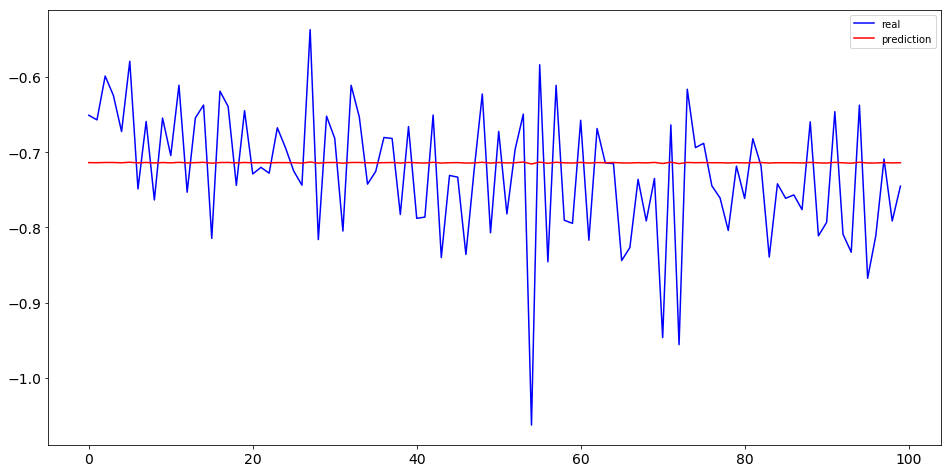

In [162]:
# 画出实际结果和预测的结果
plt.figure(figsize=(16,8)) # 设定画图板尺寸
#plt.subplot(211)

#plt.subplot(212)
#plt.plot(dataset[900:1000], 'b', label='real')
plt.plot(pred_test[900:3000], 'r', label='prediction')
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(loc='best')

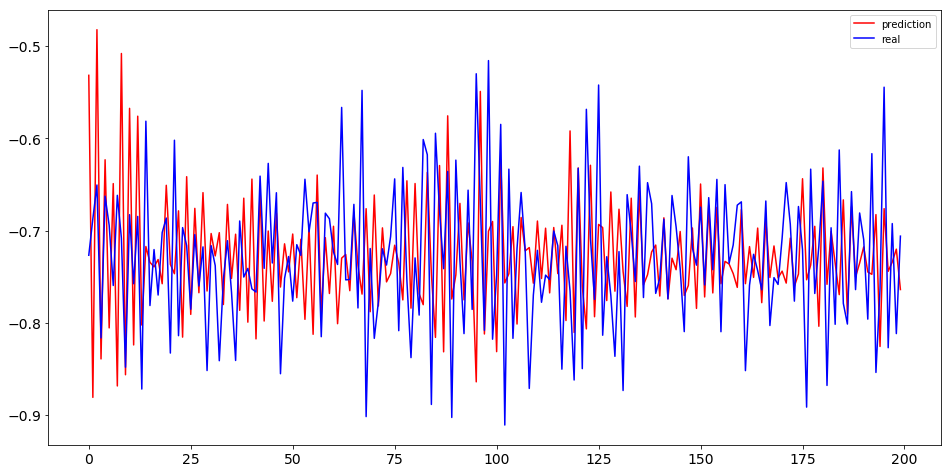

In [27]:
# 画出实际结果和预测的结果
plt.figure(figsize=(16,8)) # 设定画图板尺寸
#plt.subplot(211)
plt.plot(pred_test[2000:2200], 'r', label='prediction')
#plt.subplot(212)
plt.plot(dataset[2000:2200], 'b', label='real')
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(loc='best')

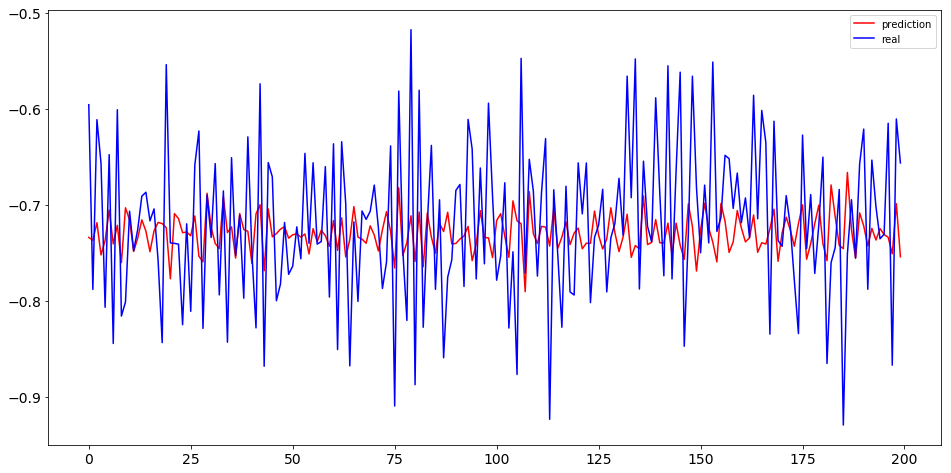

In [47]:
# 画出实际结果和预测的结果
plt.figure(figsize=(16,8)) # 设定画图板尺寸
#plt.subplot(211)
plt.plot(pred_test[-5000:-4800], 'r', label='prediction')
#plt.subplot(212)
plt.plot(dataset[-5000:-4800], 'b', label='real')
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(loc='best')

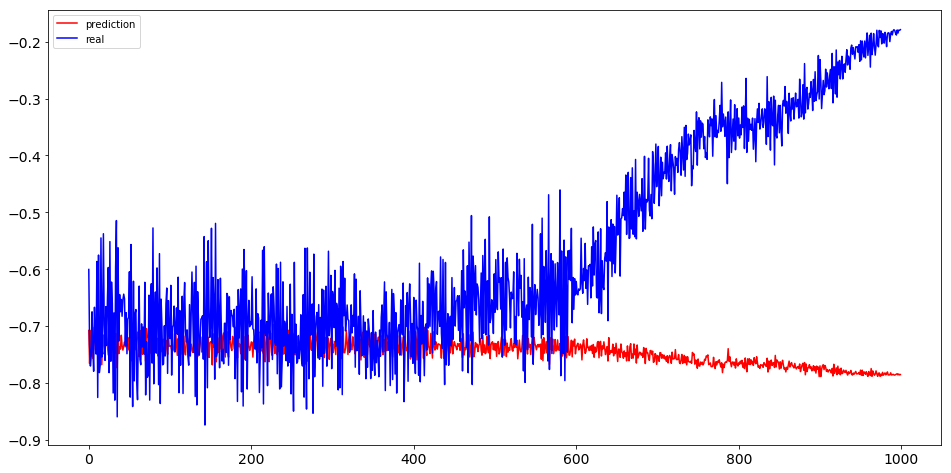

In [48]:
# 画出实际结果和预测的结果
plt.figure(figsize=(16,8)) # 设定画图板尺寸
#plt.subplot(211)
plt.plot(pred_test[-1000:], 'r', label='prediction')
#plt.subplot(212)
plt.plot(dataset[-1000:], 'b', label='real')
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(loc='best')

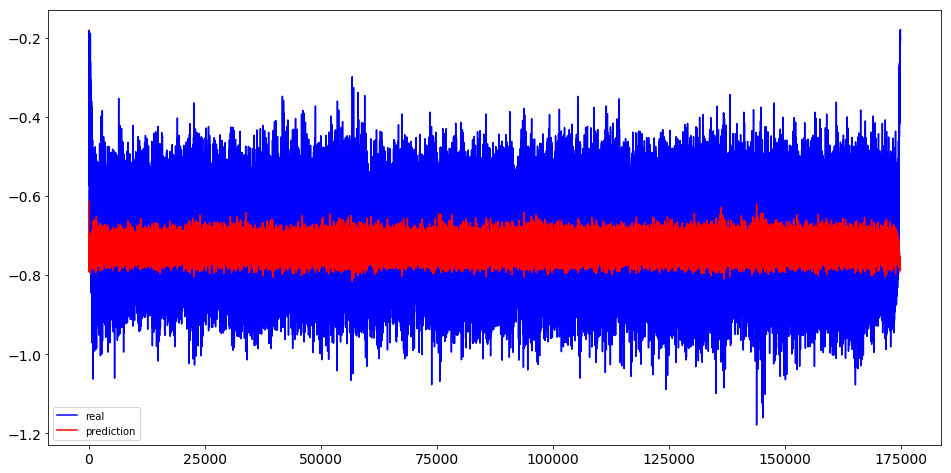

In [50]:
# 画出实际结果和预测的结果
plt.figure(figsize=(16,8)) # 设定画图板尺寸
#plt.subplot(211)
plt.plot(dataset[:], 'b', label='real')
plt.plot(pred_test[:], 'r', label='prediction')
#plt.subplot(212)

plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(loc='best')

# FFT

## 练习版本

In [ ]:
from scipy.fftpack import fft
y_01_middle = force_01_1.Fx12[50000:150000]
y_04_front = force_04_1.Fx12[1000:101000]
y_04_middle = force_04_1.Fx12[1001000:1101000]
y_04_behind = force_04_1.Fx12[1462592:1562592]

In [ ]:
type(y_01_middle)

class DoFFT():
    __init__(self, name, start, step)
    self.name = name
    self.start = start
    self.stop = step
    
    def stop(self):
        return start+step

In [ ]:
z0 = fft(y_01_middle)
z0_abs = np.abs(z0)
z0_final = z0_abs[1:]

z1 = fft(y_04_front)
z1_abs = np.abs(z1)
z1_final = z1_abs[1:]

z2 = fft(y_04_middle)
z2_abs = np.abs(z2)
z2_final = z2_abs[1:]

z3 = fft(y_04_behind)
z3_abs = np.abs(z3)
z3_final = z3_abs[1:]

#z_angle = np.angle(z)

In [ ]:
plt.subplot(4,1,1)
plt.plot(z0_final)

plt.subplot(4,1,2)
plt.plot(z1_final)

plt.subplot(4,1,3)
plt.plot(z2_final)

plt.subplot(4,1,4)
plt.plot(z3_final)

plt.show()

In [ ]:
print(z0_final[10000])
print(z1_final[10000])

## 代码版本

### 1000-101000组

In [ ]:
y = force_04_1.Fx12[1000:101000]
x = force_04_1.Time[1000:101000]
#x = np.arange(100000)
Y=fft(y)                     # 快速傅里叶变换

y_real = Y.real               # 获取实数部分
y_imag = Y.imag               # 获取虚数部分
#x.shape

In [ ]:
yf=abs(fft(y))                # 取模
yf1=abs(fft(y))/((len(x)/2))           #归一化处理
yf2 = yf1[range(int(len(x)/2))]  #由于对称性，只取一半区间

xf = np.arange(len(y))        # 频率
xf1 = xf
xf2 = xf[range(int(len(x)/2))]  #取一半区间

y_abs=abs(Y)                # 取模
y_1=abs(Y)/((len(x)/2))           #归一化处理
y_2 = y_1[range(int(len(x)/2))]  #由于对称性，只取一半区间

xf = np.arange(len(y))        # 频率
x_1 = xf
x_2 = xf[range(int(len(x)/2))]  #取一半区间

z = fft(y_front)
z_abs = np.abs(z)
z_1 = z_abs[1:]
z_angle = np.angle(z)

plt.subplot(2,1,1)
plt.plot(z_1)

plt.subplot(2,1,2)
plt.plot(z_angle)
plt.show()

In [ ]:
#原始波形
plt.subplot(221)
plt.plot(x[0:5000],y[0:5000])
plt.title('Original wave')

#混合波的FFT（双边频率范围）
plt.subplot(222)
plt.plot(xf[1:],yf[1:],'r') #显示原始信号的FFT模值
plt.title('FFT of Mixed wave(two sides frequency range)',fontsize=7,color='#7A378B')  #注意这里的颜色可以查询颜色代码表

#混合波的FFT（归一化）
plt.subplot(223)
plt.plot(x_1[1:],y_1[1:],'g')
plt.title('FFT of Mixed wave(normalization)',fontsize=9,color='r')

plt.subplot(224)
plt.plot(x_2[1:],y_2[1:],'b')
plt.title('FFT of Mixed wave)',fontsize=10,color='#F08080')


plt.show()

### 后面1462592-1562592组                 1562592

In [ ]:
y = force_04_1.Fx12[1462592:1562592]
x = force_04_1.Time[1462592:1562592]
#x = np.arange(100000)
Y=fft(y)                     # 快速傅里叶变换

y_real = Y.real               # 获取实数部分
y_imag = Y.imag               # 获取虚数部分
#x.shape

In [ ]:
yf=abs(fft(y))                # 取模
yf1=abs(fft(y))/((len(x)/2))           #归一化处理
yf2 = yf1[range(int(len(x)/2))]  #由于对称性，只取一半区间

xf = np.arange(len(y))        # 频率
xf1 = xf
xf2 = xf[range(int(len(x)/2))]  #取一半区间

y_abs=abs(Y)                # 取模
y_1=abs(Y)/((len(x)/2))           #归一化处理
y_2 = y_1[range(int(len(x)/2))]  #由于对称性，只取一半区间

xf = np.arange(len(y))        # 频率
x_1 = xf
x_2 = xf[range(int(len(x)/2))]  #取一半区间

In [ ]:
#原始波形
plt.subplot(221)
plt.plot(x[0:5000],y[0:5000])
plt.title('Original wave')

#混合波的FFT（双边频率范围）
plt.subplot(222)
plt.plot(xf[1:],yf[1:],'r') #显示原始信号的FFT模值
plt.title('FFT of Mixed wave(two sides frequency range)',fontsize=7,color='#7A378B')  #注意这里的颜色可以查询颜色代码表

#混合波的FFT（归一化）
plt.subplot(223)
plt.plot(x_1[1:],y_1[1:],'g')
plt.title('FFT of Mixed wave(normalization)',fontsize=9,color='r')

plt.subplot(224)
plt.plot(x_2[1:],y_2[1:],'b')
plt.title('FFT of Mixed wave)',fontsize=10,color='#F08080')


plt.show()

# Model

In [ ]:
class TDMSFFT():
    __init__ (self, data_0, small = -4, big = -0.1, start = 10000, step = 1000):)